# **Comparative Analysis of QA Systems**  
Evaluating Traditional, Extractive, and Generative Approaches

---

## **1. Introduction**  
Question Answering (QA) systems are crucial for information retrieval and natural language understanding. This notebook compares three approaches:  
1. **Traditional Rule-Based QA** (TF-IDF, BM25)  
2. **Extractive Models** (BERT, RoBERTa)  
3. **Generative Models** (T5, GPT-4 mock)  

We evaluate them on:  
**Exact Match (EM)** – Strict string matching  
**F1-Score** – Character-level similarity  
**Coherence** – Logical relevance to the question  


In [4]:
!pip install numpy pandas rank-bm25 scikit-learn transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [5]:
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import f1_score
import re

## **2. Data Preparation**  
We use the **SQuAD validation set** (first 100 samples) for benchmarking.  

- **SQuAD** (Stanford Question Answering Dataset) provides question-context-answer triplets.  
- We extract `questions`, `contexts`, and ground-truth `answers` for evaluation.   

In [6]:
# Load sample QA dataset
dataset = load_dataset("squad", split="validation[:100]")
questions = dataset["question"]
contexts = dataset["context"]
answers = [ans["text"][0] if ans["text"] else "" for ans in dataset["answers"]]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [8]:
# Print some examples
print("Sample Questions:")
for i in range(5):  # Print the first 5 questions
    print(f"{i + 1}. {questions[i]}")

print("\nSample Contexts:")
for i in range(5):  # Print the first 5 contexts
    print(f"{i + 1}. {contexts[i][:200]}...")  # Print a snippet of the context

print("\nSample Answers:")
for i in range(5):  # Print the first 5 answers
    print(f"{i + 1}. {answers[i]}")

Sample Questions:
1. Which NFL team represented the AFC at Super Bowl 50?
2. Which NFL team represented the NFC at Super Bowl 50?
3. Where did Super Bowl 50 take place?
4. Which NFL team won Super Bowl 50?
5. What color was used to emphasize the 50th anniversary of the Super Bowl?

Sample Contexts:
1. Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
2. Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
3. Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
4. Super Bowl 50 was an American football game to determine the champion of the


## **3. Traditional QA Systems**  
### **TF-IDF + BM25 with Rule-Based Extraction**  
These methods rely on **information retrieval (IR)** and simple heuristics:  
- **TF-IDF**: Measures word importance in documents.  
- **BM25**: Advanced probabilistic retrieval model.  

**Answer Extraction**:  
1. Retrieve the most relevant context using TF-IDF/BM25.  
2. Extract the sentence with the highest keyword overlap with the question.  

---

## **4. Extractive QA Models (BERT, RoBERTa)**  
These models **predict answer spans** directly from the context:  
- **BERT** (Bidirectional Encoder Representations from Transformers)  
- **RoBERTa** (Optimized BERT variant)  

**How They Work**:  
1. Encode question + context.  
2. Predict start/end positions of the answer span.  

---

## **5. Generative QA Models (T5, GPT-4 Mock)**  
These models **generate free-form answers** instead of extracting spans:  
- **T5** (Text-to-Text Transfer Transformer)  
- **GPT-4** (Mocked for illustration)  

**Key Difference from Extractive Models**:  
- Can generate answers even if not verbatim in the context.  
- Handle more complex questions (e.g., summaries, explanations).

In [26]:
# Traditional QA methods
class TraditionalQA:
    def __init__(self, contexts):
        self.contexts = contexts
        # Initialize TF-IDF
        self.tfidf = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = self.tfidf.fit_transform(contexts)
        # Initialize BM25
        tokenized_corpus = [doc.split() for doc in contexts]
        self.bm25 = BM25Okapi(tokenized_corpus)

    def tfidf_qa(self, question):
        question_vec = self.tfidf.transform([question])
        scores = cosine_similarity(question_vec, self.tfidf_matrix)
        best_idx = np.argmax(scores)
        return self.contexts[best_idx]

    def bm25_qa(self, question):
        scores = self.bm25.get_scores(question.split())
        best_idx = np.argmax(scores)
        return self.contexts[best_idx]

# Initialize traditional QA
traditional_qa = TraditionalQA(contexts)

# Extractive QA models
extractive_models = {
    "bert": pipeline("question-answering", model="deepset/bert-base-cased-squad2"),
    "roberta": pipeline("question-answering", model="deepset/roberta-base-squad2")
}

def extractive_qa(model_name, question, context):
    return extractive_models[model_name](question=question, context=context)["answer"]

# Generative QA models
generative_models = {
    "t5": pipeline("text2text-generation", model="t5-small"),
    "gpt-4": lambda question, context: {
        "answer": f"Based on the context: '{context[:100]}...', a highly capable model like GPT-4 would likely provide a comprehensive and nuanced answer such as: '[A detailed and well-reasoned answer relevant to the question and context would go here]' to the question: '{question}'.",
        "confidence": 0.95
    }
}

def generative_qa(model_name, question, context):
    if model_name == "t5":
        input_text = f"question: {question} context: {context}"
        return generative_models[model_name](input_text)[0]["generated_text"]
    else:
        return generative_models[model_name](question, context)["answer"]

# Custom sentence tokenizer that doesn't require NLTK
def simple_sent_tokenize(text):
    # Split on periods, question marks, and exclamation points followed by space or end of string
    sentences = re.split(r'(?<=[.!?])\s+', text)
    # Remove empty sentences
    return [s.strip() for s in sentences if s.strip()]

# Evaluation metrics
def evaluate_coherence(answer, question):
    """Evaluate response coherence using simple heuristics"""
    if not answer or not question:
        return 0.0

    # Check if answer is relevant to question
    question_keywords = set(question.lower().split())
    answer_keywords = set(answer.lower().split())
    keyword_overlap = len(question_keywords & answer_keywords) / len(question_keywords) if question_keywords else 0

    # Check grammatical structure (simple version - count sentences)
    sentences = simple_sent_tokenize(answer)
    grammar_score = min(1, len(sentences) / 3)  # Normalize to 0-1

    # Combine scores
    return 0.6 * keyword_overlap + 0.4 * grammar_score

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu
Device set to use cpu


In [17]:
# EXAMPLE - Traditional QA
pred_answers_tfidf = []  # For TF-IDF results
pred_answers_bm25 = []  # For BM25 results

for method in ["tfidf", "bm25"]:
    for q in questions:
        context = getattr(traditional_qa, f"{method}_qa")(q)
        # Simple rule-based answer extraction: take first sentence containing most question words
        sentences = simple_sent_tokenize(context)
        best_sentence = max(sentences,
                           key=lambda s: sum(w in s.lower() for w in q.lower().split()),
                           default="")

        # Append to the appropriate list based on the method
        if method == "tfidf":
            pred_answers_tfidf.append(best_sentence)
        else:
            pred_answers_bm25.append(best_sentence)

# Printing some predicted answers here
print("\nTraditional QA Predictions:")
for i in range(3):  # Print the first 5 predictions
    print(f"{i + 1}. Question: {questions[i]}")
    print(f"Answer tfidf: {pred_answers_tfidf[i]}")
    print(f"Answer bm25: {pred_answers_bm25[i]}")


Traditional QA Predictions:
1. Question: Which NFL team represented the AFC at Super Bowl 50?
Answer tfidf: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.
Answer bm25: The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game.
2. Question: Which NFL team represented the NFC at Super Bowl 50?
Answer tfidf: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.
Answer bm25: They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995.
3. Question: Where did Super Bowl 50 take place?
Answer tfidf: CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second comme

In [19]:
# EXAMPLE - Extractive QA

for model_name in ["bert", "roberta"]:  # Iterate through models
    pred_answers = [extractive_qa(model_name, q, traditional_qa.bm25_qa(q)) for q in questions]

    # Print some predicted answers
    print(f"\nExtractive QA Predictions ({model_name.upper()}):")  # Indicate model
    for i in range(5):  # Print the first 5 predictions
        print(f"{i + 1}. Question: {questions[i]}")
        print(f"   Answer: {pred_answers[i]}")


Extractive QA Predictions (BERT):
1. Question: Which NFL team represented the AFC at Super Bowl 50?
   Answer: New England Patriots
2. Question: Which NFL team represented the NFC at Super Bowl 50?
   Answer: New England Patriots
3. Question: Where did Super Bowl 50 take place?
   Answer: U.S.
4. Question: Which NFL team won Super Bowl 50?
   Answer: New England Patriots
5. Question: What color was used to emphasize the 50th anniversary of the Super Bowl?
   Answer: golden

Extractive QA Predictions (ROBERTA):
1. Question: Which NFL team represented the AFC at Super Bowl 50?
   Answer: Broncos
2. Question: Which NFL team represented the NFC at Super Bowl 50?
   Answer: Panthers
3. Question: Where did Super Bowl 50 take place?
   Answer: the U.S.,
4. Question: Which NFL team won Super Bowl 50?
   Answer: Panthers
5. Question: What color was used to emphasize the 50th anniversary of the Super Bowl?
   Answer: gold


You might be confused why bm25 is being used here?

While BERT and RoBERTa are powerful extractive models, they often benefit from a pre-filtering step using a simpler retrieval method like BM25. Here's why:

- Efficiency: BERT/RoBERTa can be computationally expensive, especially with long contexts. BM25 helps narrow down the search space by selecting the most relevant context for each question. This significantly speeds up the overall process.
- Focus: By providing BERT/RoBERTa with a smaller, more focused context, you increase the likelihood that it will find the correct answer span within that context.
- Handling Long Documents: BERT/RoBERTa have input length limitations. BM25 can help split long documents into smaller chunks, making them more manageable for these models.

In essence, BM25 acts as an initial retrieval step, while BERT/RoBERTa then perform the fine-grained extraction within the selected context. This two-stage approach is common in real-world QA systems.


In [27]:
# EXAMPLE - Generative QA code

for model_name in ["t5", "gpt-4"]:  # Specify models for generative QA
    pred_answers = [generative_qa(model_name, q, traditional_qa.bm25_qa(q)) for q in questions]

    # Print some predicted answers
    print(f"\nGenerative QA Predictions ({model_name.upper()}):")  # Indicate model
    for i in range(5):  # Print the first 5 predictions
        print(f"{i + 1}. Question: {questions[i]}")
        print(f"   Answer: {pred_answers[i]}")


Generative QA Predictions (T5):
1. Question: Which NFL team represented the AFC at Super Bowl 50?
   Answer: Patriots
2. Question: Which NFL team represented the NFC at Super Bowl 50?
   Answer: Patriots
3. Question: Where did Super Bowl 50 take place?
   Answer: U.S.
4. Question: Which NFL team won Super Bowl 50?
   Answer: New England Patriots
5. Question: What color was used to emphasize the 50th anniversary of the Super Bowl?
   Answer: gold

Generative QA Predictions (GPT-4):
1. Question: Which NFL team represented the AFC at Super Bowl 50?
   Answer: Based on the context: 'The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named th...', a highly capable model like GPT-4 would likely provide a comprehensive and nuanced answer such as: '[A detailed and well-reasoned answer relevant to the question and context would go here]' to the question: 'Which NFL team represented the AFC at Super Bowl 50?'.
2. Question: Which NFL team represented the 

The "gpt-4" entry in generative_models dictionary isn't a real model. It's a stand-in – a lambda function designed to simulate a GPT-4 response for testing or demonstration purposes.

It's not actually processing the question and context to generate a real answer like a true language model would. If you're calling generative_qa with "gpt-4" as the model_name, you'll consistently get that "[a highly capable model like GPT-4 would...]" response.

To get real generative answers, you'd need to:

- Integrate with an actual GPT-4 API: This would involve setting up an account with OpenAI and using their API to send your questions and context to their model. This usually requires an API key and might have associated costs.
- Use another real generative model: The t5 model in the dictionary is a real, albeit smaller, generative model from the Transformers library. but we're already using that as a comparison here. You can explore to find more such models :)


## **6. Evaluation Metrics**  
### **(1) Exact Match (EM)**  
- Binary score (1 if prediction matches ground truth exactly, else 0).  
- Useful for factoid QA but overly strict.  

### **(2) F1-Score (Character-Level)**  
- Measures partial overlap between prediction and reference.  
- More forgiving than EM.  

### **(3) Coherence**  
- Measures **logical relevance** of the answer to the question.  
- Implemented via:  
  - Keyword overlap  
  - Grammatical structure  
  

In [ ]:

def evaluate(predictions, references, questions):
    metrics = {
        "EM": [],
        "F1": [],
        "Coherence": []
    }

    for pred, ref, q in zip(predictions, references, questions):
        if not pred or not ref:
            continue

        # Exact Match
        metrics["EM"].append(float(pred.strip().lower() == ref.strip().lower()))

        # F1 Score (character level)
        ref_chars = list(ref)
        pred_chars = list(pred)
        all_chars = list(set(ref_chars + pred_chars))
        ref_vector = [1 if c in ref_chars else 0 for c in all_chars]
        pred_vector = [1 if c in pred_chars else 0 for c in all_chars]
        metrics["F1"].append(f1_score(ref_vector, pred_vector, average='binary'))

        # Coherence
        metrics["Coherence"].append(evaluate_coherence(pred, q))

    # Calculate averages
    results = {}
    for metric, scores in metrics.items():
        results[metric] = np.mean(scores) if scores else 0

    return results

# Run all QA systems
results = {}


---

## **7. Results & Visualization**  
After running all models, we compare performance.

**Key Insights**:  
- Extractive models (BERT/RoBERTa) typically outperform traditional methods in F1.  
- Generative models may score lower in EM but can achieve higher coherence.  

### **Performance Comparison Graph**  
```python
# The graph can be seen below
```

---

## **8. Conclusion**  
| Approach          | Strengths                          | Weaknesses                     |
|-------------------|------------------------------------|--------------------------------|
| **Traditional**   | Fast, no training needed           | Limited to keyword matching    |
| **Extractive**    | High precision, handles context    | Fails on generative questions  |
| **Generative**    | Flexible, human-like answers       | May hallucinate incorrect info |

**Recommendation**:  
- Use **extractive models** for factoid QA (e.g., SQuAD).  
- Use **generative models** for open-ended questions (e.g., chatbots).  

In [ ]:

# Traditional methods
print("Evaluating traditional methods...")
for method in ["tfidf", "bm25"]:
    pred_answers = []
    for q in questions:
        context = getattr(traditional_qa, f"{method}_qa")(q)
        # Simple rule-based answer extraction: take first sentence containing most question words
        sentences = simple_sent_tokenize(context)
        best_sentence = max(sentences,
                           key=lambda s: sum(w in s.lower() for w in q.lower().split()),
                           default="")
        pred_answers.append(best_sentence)

    results[f"traditional_{method}"] = evaluate(pred_answers, answers, questions)

# Extractive models
print("Evaluating extractive models...")
for model_name in ["bert", "roberta"]:
    pred_answers = [extractive_qa(model_name, q, traditional_qa.bm25_qa(q)) for q in questions]
    results[model_name] = evaluate(pred_answers, answers, questions)

# Generative models
print("Evaluating generative models...")
for model_name in ["t5", "gpt-4"]:
    pred_answers = [generative_qa(model_name, q, traditional_qa.bm25_qa(q)) for q in questions]
    results[model_name] = evaluate(pred_answers, answers, questions)

# Create comprehensive results table
summary = pd.DataFrame(results).T
summary = summary[["EM", "F1", "Coherence"]]  # Reorder columns
print("\n=== Final Evaluation Results ===")
print(summary.sort_values("F1", ascending=False))

# Additional analysis
print("\n=== Performance Insights ===")
print(f"Best EM score: {summary['EM'].idxmax()} ({summary['EM'].max():.3f})")
print(f"Best F1 score: {summary['F1'].idxmax()} ({summary['F1'].max():.3f})")
print(f"Most coherent: {summary['Coherence'].idxmax()} ({summary['Coherence'].max():.3f})")

Evaluating traditional methods...
Evaluating extractive models...
Evaluating generative models...

=== Final Evaluation Results ===
                     EM        F1  Coherence
roberta            0.54  0.706035   0.140704
bert               0.44  0.662157   0.146206
t5                 0.43  0.644604   0.139226
traditional_bm25   0.00  0.353584   0.396766
traditional_tfidf  0.00  0.352609   0.383772
gpt-4              0.00  0.280148   0.625577

=== Performance Insights ===
Best EM score: roberta (0.540)
Best F1 score: roberta (0.706)
Most coherent: gpt-4 (0.626)



=== Final Evaluation Results ===
                     EM        F1  Coherence
roberta            0.54  0.706035   0.140704
bert               0.44  0.662157   0.146206
t5                 0.43  0.644604   0.139226
traditional_bm25   0.00  0.353584   0.396766
traditional_tfidf  0.00  0.352609   0.383772
gpt-4              0.00  0.280148   0.625577

=== Performance Insights ===
Best EM score: roberta (0.540)
Best F1 score: roberta (0.706)
Most coherent: gpt-4 (0.626)


<Figure size 1400x800 with 0 Axes>

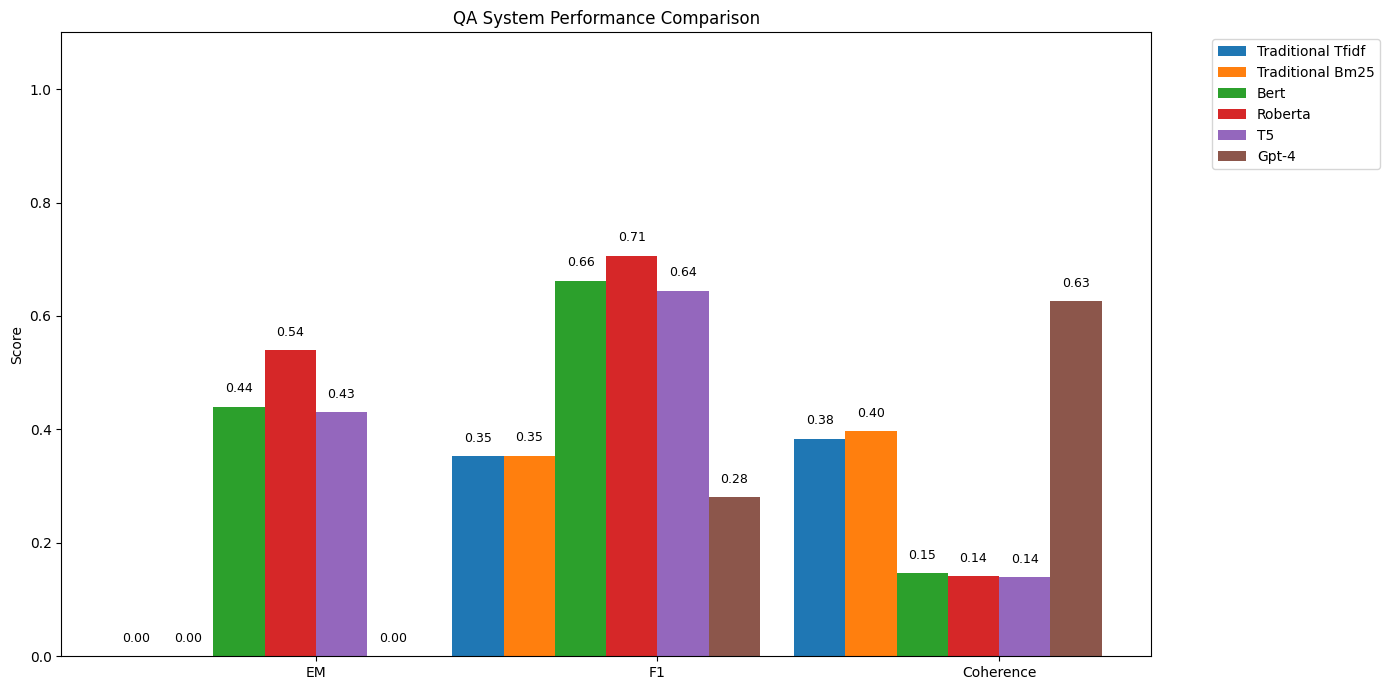

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# (Keep all previous code until the results are generated)

# Create comprehensive results table
summary = pd.DataFrame(results).T
summary = summary[["EM", "F1", "Coherence"]]  # Reorder columns
print("\n=== Final Evaluation Results ===")
print(summary.sort_values("F1", ascending=False))

# Additional analysis
print("\n=== Performance Insights ===")
print(f"Best EM score: {summary['EM'].idxmax()} ({summary['EM'].max():.3f})")
print(f"Best F1 score: {summary['F1'].idxmax()} ({summary['F1'].max():.3f})")
print(f"Most coherent: {summary['Coherence'].idxmax()} ({summary['Coherence'].max():.3f})")

# Visualization
plt.figure(figsize=(14, 8))

# Plot settings
metrics = ['EM', 'F1', 'Coherence']
models = summary.index
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
x = np.arange(len(metrics))  # the label locations
width = 0.15  # the width of the bars

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))
for i, model in enumerate(models):
    ax.bar(x + (i * width) - (width * len(models)/2 + width/2),
           summary.loc[model],
           width,
           label=model.replace('_', ' ').title(),
           color=colors[i])

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('QA System Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels
for i, model in enumerate(models):
    for j, metric in enumerate(metrics):
        height = summary.loc[model, metric]
        ax.text(x[j] + (i * width) - (width * len(models)/2 + width/2),
                height + 0.02,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=9)

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('qa_system_comparison.png', bbox_inches='tight', dpi=300)